In [122]:
import os
from glob import glob

# CHANGE THESE TO YOUR MOL AND JDX FOLDERS
MOL_FOLDER = 'C:\\Users\\20234238\\Year_2\\Q4\\Untitled Folder\\scraper\\mol'
JDX_FOLDER = 'C:\\Users\\20234238\\Year_2\\Q4\\Untitled Folder\\scraper\\jdx'

mol_files = glob(os.path.join(MOL_FOLDER, '*.mol'))
jdx_files = glob(os.path.join(JDX_FOLDER, '*.jdx'))

jdx_cas_to_jdx_path = {}
for jdx_path in jdx_files:
    jdx_cas_with_index = os.path.splitext(os.path.basename(jdx_path))[0]
    jdx_cas_to_jdx_path[jdx_cas_with_index] = os.path.abspath(jdx_path)
    
mol_to_jdx = {}

# Find out which .jdx files belong to which .mol files
for mol_path in mol_files:
    mol_cas = os.path.splitext(os.path.basename(mol_path))[0]
    matching_jdx = []
    
    index = 0
    while (True):
        cas_with_index = mol_cas + ("-IR-%i" % (index))
        if cas_with_index in jdx_cas_to_jdx_path:
            matching_jdx.append(jdx_cas_to_jdx_path[cas_with_index])
            index = index + 1
        else:
            break
    
    mol_to_jdx[os.path.abspath(mol_path)] = matching_jdx
    
#print('Files:')
#for mol_file, jdx_list in mol_to_jdx.items():
#    print('\nMOL: %s' % (mol_file))
#    for jdx_file in jdx_list:
#        print("\tJDX: %s" % (jdx_file))

In [124]:
import jcamp

# NOTE WHEN DEBUGGING THIS:
# If you run this block and the validity constraint is too tight (ie eliminates too many jdx files)
# Run the file above again to reinstate the files.

MIN_WAVENUMBER = 400
MAX_WAVENUMBER = 4000
COVER_THRESHOLD = 0.25

def is_jdx_valid(jdx_file):
    jcamp_dict = jcamp.jcamp_readfile(jdx_file)
    
    # Some very old spectra don't have jdx files yet NIST provides downloads for them anyway.
    # These files don't have any measurements and sometimes don't even include the npoints tag so we filter them out.
    if ((not 'npoints' in jcamp_dict) or jcamp_dict['npoints'] < 1):
        #print('NO DATAPOINTS')
        return False
    
    # Some spectra use y units like absorption/refraction index as their y units.
    # These can't be easily converted to absorbance/transmittance and the jcamp library parses them wrong so we filter them out.
    if (jcamp_dict['yunits'].lower() != 'transmittance' and jcamp_dict['yunits'].lower() != 'absorbance'):
        #print('UNCLEAR UNITS')
        return False
    
    if ((not 'maxx' in jcamp_dict) or (not 'minx' in jcamp_dict) or (not 'xunits' in jcamp_dict)):
        #print('LACKS VITAL DATA')
        return False
    
    # We first have to make sure our first/last x are given in cm^-1
    min_x = jcamp_dict['minx']
    max_x = jcamp_dict['maxx']
    if (jcamp_dict['xunits'].lower() == 'micrometers'):
        min_x = 1e4 / min_x
        max_x = 1e4 / max_x
        
    # Since we only care for the spectrum from wavenumbers MIN_WAVENUMBER to MAX_WAVENUMBER, we disregard any coverage outside that range.
    min_x = max(min_x, MIN_WAVENUMBER)
    max_x = min(max_x, MAX_WAVENUMBER)
    
    # Some samples only cover a very small range of wavelengths. This is generally bad so we filter them out.
    cover = (max_x - min_x) / (MAX_WAVENUMBER - MIN_WAVENUMBER)
    if (cover < COVER_THRESHOLD):
        #print('LACKS COVERAGE')
        return False
    
    return True

initial_jdx_count = 0
for mol_file, jdx_list in mol_to_jdx.items():
    initial_jdx_count = initial_jdx_count + len(jdx_list)
    mol_to_jdx[mol_file] = [jdx for jdx in jdx_list if is_jdx_valid(jdx)]
    
# Remove .mol files for which there is no (valid) IR data
for key in list(mol_to_jdx):
    if mol_to_jdx[key] == []:
        del mol_to_jdx[key]

jdx_count = 0
for mol_file, jdx_list in mol_to_jdx.items():
    for jdx_file in jdx_list:
        jdx_count = jdx_count + 1

print('Reduced from %i .jdx files to %i .jdx files' % (initial_jdx_count, jdx_count))
print('Currently there are %i .jdx files corresponding to %i .mol files' % (jdx_count, len(mol_to_jdx)))

Reduced from 7952 .jdx files to 7030 .jdx files
Currently there are 7030 .jdx files corresponding to 6321 .mol files


In [125]:
import re
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pandas as pd
import matplotlib.pyplot as plt


# SMARTS taken from Jung, G. et al
functional_group_patterns = {
    #'group_name': Chem.MolFromSmarts['smarts_code']
    'alkane': Chem.MolFromSmarts('[CX4;H3,H2]'),
    'alkene': Chem.MolFromSmarts('[CX3]=[CX3]'),
    'alkyne': Chem.MolFromSmarts('[CX2]#[CX2]'),
    'arene': Chem.MolFromSmarts('[cX3]1[cX3][cX3][cX3][cX3][cX3]1'),
    'haloalkane': Chem.MolFromSmarts('[#6][F,Cl,Br,I]'),
    'alcohol': Chem.MolFromSmarts('[#6][OX2H]'),
    'aldehyde': Chem.MolFromSmarts('[CX3H1](=O)[#6,H]'),
    'ketone': Chem.MolFromSmarts('[#6][CX3](=O)[#6]'),
    'carboxylic_acid': Chem.MolFromSmarts('[CX3](=O)[OX2H]'),
    'acid_anhydride': Chem.MolFromSmarts('[CX3](=[OX1])[OX2][CX3](=[OX1])'),
    'acyl_halide': Chem.MolFromSmarts('[CX3](=[OX1])[F,Cl,Br,I]'),
    'ester': Chem.MolFromSmarts('[#6][CX3](=O)[OX2H0][#6]'),
    'ether': Chem.MolFromSmarts('[OD2]([#6])[#6]'),
    'amine': Chem.MolFromSmarts('[NX3;H2,H1,H0;!$(NC=O)]'),
    'amide': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[#6]'),
    'nitrile': Chem.MolFromSmarts('[NX1]#[CX2]'),
    'imide': Chem.MolFromSmarts('[CX3](=[OX1])[NX3][CX3](=[OX1])'),
    'imine': Chem.MolFromSmarts('[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]'),
    'azo_compound': Chem.MolFromSmarts('[#6][NX2]=[NX2][#6]'),
    'thiol': Chem.MolFromSmarts('[#16X2H]'),
    'thial': Chem.MolFromSmarts('[CX3H1](=O)[#6,H]'),
    'sulfone': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[#6]'),
    'sulfonic_acid': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[OX2H]'),
    'enol': Chem.MolFromSmarts('[OX2H][#6X3]=[#6]'),
    'phenol': Chem.MolFromSmarts('[OX2H][cX3]:[c]'),
    'hydrazine': Chem.MolFromSmarts('[NX3][NX3]'),
    'enamine': Chem.MolFromSmarts('[NX3][CX3]=[CX3]'),
    'isocyanate': Chem.MolFromSmarts('[NX2]=[C]=[O]'),
    'isothiocyanate': Chem.MolFromSmarts('[NX2]=[C]=[S]'),
    'phosphine': Chem.MolFromSmarts('[PX3]'),
    'sulfonamide': Chem.MolFromSmarts('[#16X4]([NX3])(=[OX1])(=[OX1])[#6]'),
    'sulfonate': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[OX2H0]'),
    'sulfoxide': Chem.MolFromSmarts('[#16X3]=[OX1]'),
    'thioamide': Chem.MolFromSmarts('[NX3][CX3]=[SX1]'),
    'hydrazone': Chem.MolFromSmarts('[NX3][NX2]=[#6]'),
    'carbamate': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[OX2H0]'),
    'sulfide': Chem.MolFromSmarts('[#16X2H0]')
}

def determine_functional_groups(mol_file):
    mol = Chem.MolFromMolFile(mol_file)
    
    if mol is None:
        return []
    
    functional_groups = []
    for functional_group in functional_group_patterns:
        if mol.HasSubstructMatch(functional_group_patterns[functional_group]):
            functional_groups.append(functional_group)
    return functional_groups


def get_state(jdx_file):
    try:
        with open(jdx_file, 'r') as file:
            lines = file.readlines()
            
            for line in lines:
                if line.startswith('##STATE='):
                    state = line[len('##STATE='):].strip().lower()
                    return re.split(r"[;, ()]+", state)[0]
            return 'Unknown'
    except FileNotFoundError:
        print('File %s does not exist!' % (jdx_file))
        return False

mol_to_labels = {}
    
molecules_with_functional_group = {}
samples_with_functional_group = {}

number_of_functional_groups_mols = []
number_of_functional_groups_samples = []

states = {}


for mol_file, jdx_list in mol_to_jdx.items():
    functional_groups = determine_functional_groups(mol_file)
    mol_to_labels[mol_file] = functional_groups
    
    # Functional groups
    for functional_group in functional_groups:
        if functional_group in molecules_with_functional_group:
            molecules_with_functional_group[functional_group] = molecules_with_functional_group[functional_group] + 1
            samples_with_functional_group[functional_group] = samples_with_functional_group[functional_group] + len(mol_to_jdx[mol_file])
        else:
            molecules_with_functional_group[functional_group] = 1
            samples_with_functional_group[functional_group] = len(mol_to_jdx[mol_file])
            
    # Number of functional groups
    number_of_groups = len(functional_groups)
    if (number_of_groups < len(number_of_functional_groups_mols)):
        number_of_functional_groups_mols[number_of_groups] = number_of_functional_groups_mols[number_of_groups] + 1
        number_of_functional_groups_samples[number_of_groups] = number_of_functional_groups_samples[number_of_groups] + len(mol_to_jdx[mol_file])
    else:
        number_of_functional_groups_mols.insert(number_of_groups, 1)
        number_of_functional_groups_samples.insert(number_of_groups, len(mol_to_jdx[mol_file]))
        
    # Spectrum states
    for jdx_file in jdx_list:
        state = get_state(jdx_file)
        if state in states:
            states[state] = states[state] + 1
        else:
            states[state] = 1
            
print(molecules_with_functional_group)
print(samples_with_functional_group)

print(number_of_functional_groups_mols)
print(number_of_functional_groups_samples)

print(states)

{'arene': 3081, 'haloalkane': 1548, 'amine': 1353, 'alcohol': 1309, 'phenol': 312, 'alkane': 4861, 'ketone': 511, 'ether': 1612, 'aldehyde': 134, 'thial': 134, 'alkene': 786, 'nitrile': 260, 'thiol': 85, 'hydrazine': 65, 'carbamate': 62, 'amide': 417, 'alkyne': 116, 'carboxylic_acid': 386, 'hydrazone': 17, 'sulfide': 302, 'ester': 761, 'phosphine': 24, 'azo_compound': 16, 'sulfone': 53, 'isocyanate': 30, 'imide': 87, 'isothiocyanate': 132, 'sulfonamide': 65, 'acyl_halide': 57, 'sulfonic_acid': 7, 'imine': 44, 'sulfonate': 12, 'acid_anhydride': 27, 'thioamide': 27, 'enamine': 25, 'enol': 4, 'sulfoxide': 15}
{'arene': 3387, 'haloalkane': 1715, 'amine': 1466, 'alcohol': 1437, 'phenol': 350, 'alkane': 5418, 'ketone': 572, 'ether': 1776, 'aldehyde': 151, 'thial': 151, 'alkene': 892, 'nitrile': 285, 'thiol': 90, 'hydrazine': 66, 'carbamate': 62, 'amide': 443, 'alkyne': 119, 'carboxylic_acid': 412, 'hydrazone': 18, 'sulfide': 318, 'ester': 856, 'phosphine': 27, 'azo_compound': 18, 'sulfone': 

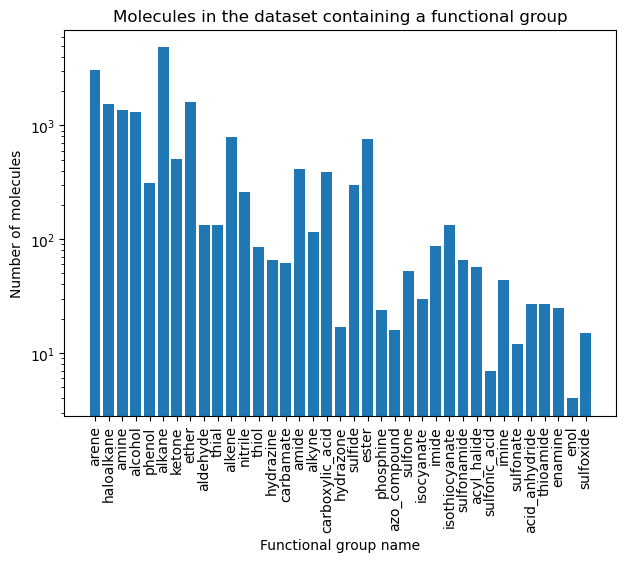

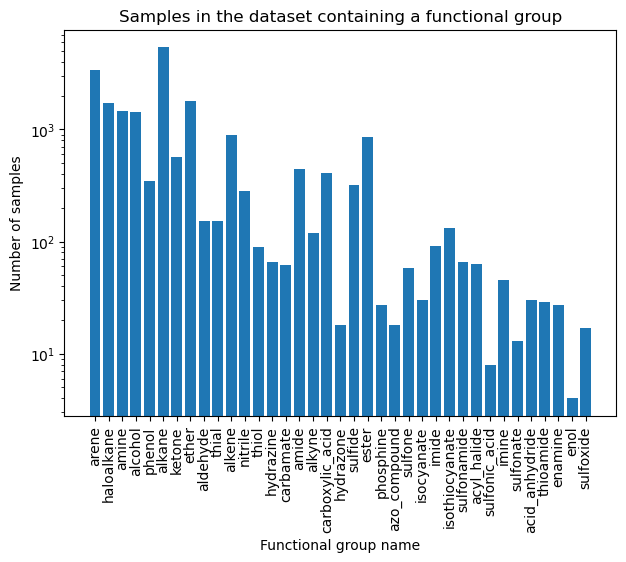

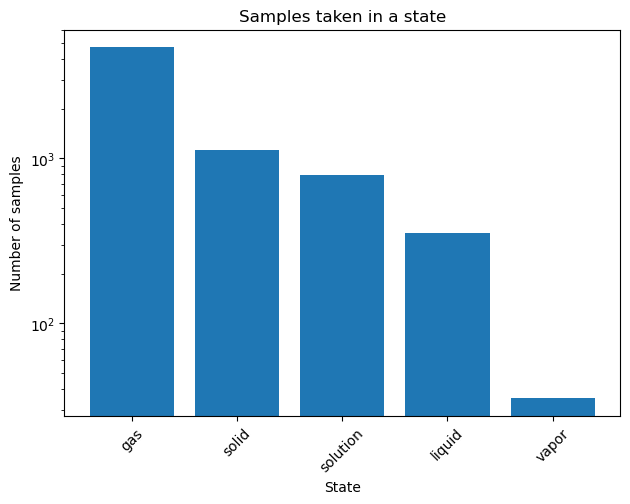

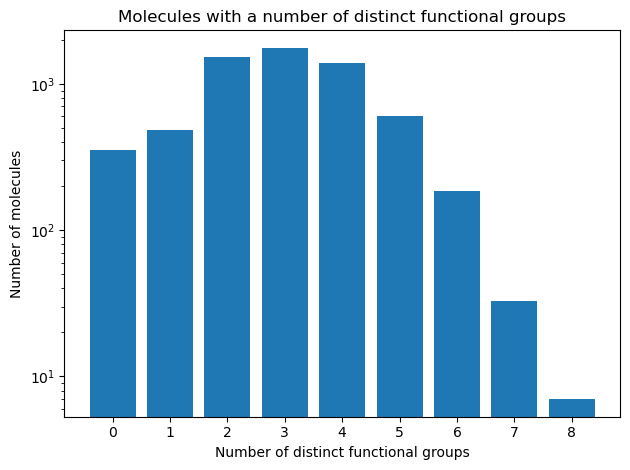

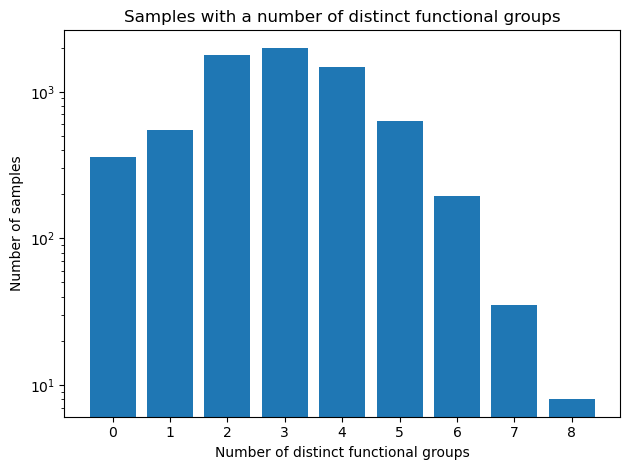

In [126]:
# Used to prevent states with only a few samples from cluttering the state graph 
DISPLAY_THRESHOLD = 20
# CHANGE THIS TO THE FOLDER WHERE YOU WANT TO SAVE THE GRAPHS
PLT_PATH = 'plot_images'

# FUNCTIONAL GROUP COUNTS MOLECULES
group_names_mol = list(molecules_with_functional_group.keys())
group_counts_mol = list(molecules_with_functional_group.values())

plt.bar(group_names_mol, group_counts_mol)
plt.xlabel('Functional group name')
plt.ylabel('Number of molecules')
plt.yscale('log')
plt.title('Molecules in the dataset containing a functional group')
plt.tight_layout()
plt.xticks(rotation=90)

plt_path = os.path.join(PLT_PATH, 'functional_groups_mol.png')
#bbox_inches is needed to prevent some of the labels from getting cropped out
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# FUNCTIONAL GROUP COUNTS SAMPLES/SPECTRA
group_names_samples = list(samples_with_functional_group.keys())
group_counts_samples = list(samples_with_functional_group.values())

plt.bar(group_names_samples, group_counts_samples)
plt.xlabel('Functional group name')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.title('Samples in the dataset containing a functional group')
plt.tight_layout()
plt.xticks(rotation=90)

plt_path = os.path.join(PLT_PATH, 'functional_groups_sample.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# SAMPLE/SPECTRUM STATES
state_names = [state for state in list(states.keys()) if states[state] >= DISPLAY_THRESHOLD]
state_counts = [count for count in list(states.values()) if count >= DISPLAY_THRESHOLD]
plt.bar(state_names, state_counts)
plt.xlabel('State')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.title('Samples taken in a state')
plt.tight_layout()
plt.xticks(rotation=45)

plt_path = os.path.join(PLT_PATH, 'states.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# NUMBER OF MOLECULES WITH SOME NUMBER OF UNIQUE FUNCTIONAL GROUPS
plt.bar(range(len(number_of_functional_groups_mols)), number_of_functional_groups_mols)
plt.xlabel('Number of distinct functional groups')
plt.ylabel('Number of molecules')
plt.yscale('log')
plt.title('Molecules with a number of distinct functional groups')
plt.xticks(ticks=range(len(number_of_functional_groups_mols)))
plt.tight_layout()

plt_path = os.path.join(PLT_PATH, 'number_of_groups_mol.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

# NUMBER OF SAMPLES WITH SOME NUMBER OF UNIQUE FUNCTIONAL GROUPS
plt.bar(range(len(number_of_functional_groups_samples)), number_of_functional_groups_samples)
plt.xlabel('Number of distinct functional groups')
plt.ylabel('Number of samples')
plt.yscale('log')
plt.title('Samples with a number of distinct functional groups')
plt.xticks(ticks=range(len(number_of_functional_groups_samples)))
plt.tight_layout()

plt_path = os.path.join(PLT_PATH, 'number_of_groups_sample.png')
plt.savefig(plt_path, bbox_inches='tight')
plt.show()

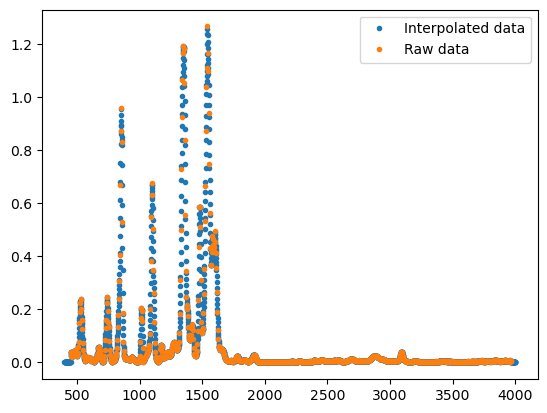

array([0., 0., 0., ..., 0., 0., 0.])

In [129]:
import numpy as np
from scipy.interpolate import interp1d
import csv

CSV_PATH = 'spectra.csv'

def preprocess_spectrum(jdx_file):
    jcamp_dict = jcamp.jcamp_readfile(jdx_file)
    
    yvals_raw = jcamp_dict['y']
    yunits = jcamp_dict['yunits'].lower()
    
    xvals_raw = jcamp_dict['x']
    xunits = jcamp_dict['xunits'].lower()
    
    if (xunits == 'micrometers'):
        # wavenumber = 10^4 / wavelength
        xvals_raw = 1e4 / xvals_raw 
        
    # Convert all y values to absorbance
    if (yunits == 'transmittance'):
        yvals_raw = -np.log10(yvals_raw)
    
    interpolator = interp1d(xvals_raw, yvals_raw, kind='linear', fill_value=0, bounds_error=False)
    xvals_new = np.linspace(MIN_WAVENUMBER, MAX_WAVENUMBER, MAX_WAVENUMBER - MIN_WAVENUMBER)
    yvals_new = interpolator(xvals_new)
    

    # TODO normalize
    
    # For debugging
    plt.plot(xvals_new, yvals_new, '.', label='Interpolated data')
    plt.plot(xvals_raw, yvals_raw, '.', label='Raw data')
    plt.legend()
    plt.show()
    
    return yvals_new

# DONT UNCOMMENT THE CSV WRITER LINES IT WILL WRITE A 10GB FILE TO YOUR PC AND HOG ALL THE RESOURCES
#with open(CSV_PATH, 'w', newline='') as file:
#    writer = csv.writer(file)
    
#    for mol_file, jdx_list in mol_to_jdx.items():
#        for jdx_file in jdx_list:
#            print(jdx_file)
#            yvals = preprocess_spectrum(jdx_file)
            
            #labels = mol_to_labels[mol_file]
            
            #writer.writerow(labels)
            #writer.writerow(yvals)
    
        
        
test_item = next(iter(mol_to_jdx.items()))
preprocess_spectrum(test_item[1][0])